# prediction xgboost 백테스팅
# 피처 추가 제외 v01
- 267 >> 217 >> 194
- B00_01에서 하단 피처성능 셀 참고하여 추가로 제외할 수 있음.

### 차트 시각화

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [2]:
class SimpleBacktester:
    def __init__(self, data_path, start_date='2021-09-07', end_date='2023-12-31'):
        """
        예측 라벨용 개별 종목 백테스터 (신호 반전)
        """
        self.data_path = data_path
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.stocks_data = {}
        self.results = {}
        
        self.top_performers = []
        self.top_performers_dict = {}
        
        self.top_strategy_performers = []
        self.top_strategy_performers_dict = {}
        
    def load_data(self):
        """CSV 파일들 로딩"""
        patterns = ["*_complete.csv"]
        csv_files = []
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.data_path, pattern))
            if files:
                csv_files = files
                print(f"파일 패턴 발견: {pattern} ({len(files)}개)")
                break
        
        if not csv_files:
            raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"CSV 파일 로딩 중... ({len(csv_files)}개)")
        
        for file_path in tqdm(csv_files):
            try:
                filename = os.path.basename(file_path)
                symbol = filename.replace('_complete.csv', '')
                
                df = pd.read_csv(file_path)
                
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'])
                else:
                    continue
                
                required_cols = ['Date', 'Close', 'Predicted_Label', 'Predicted_Action']
                if not all(col in df.columns for col in required_cols):
                    print(f"필수 컬럼 누락: {symbol}")
                    continue

                df['Label'] = df['Predicted_Label']
                df['Label_Name'] = df['Predicted_Action']

                date_mask = (df['Date'] >= self.start_date) & (df['Date'] <= self.end_date)
                df = df[date_mask]
                
                df = df.sort_values('Date').reset_index(drop=True)

                if len(df) > 50:
                    self.stocks_data[symbol] = df
                    
            except Exception as e:
                print(f"파일 로딩 실패: {filename} - {e}")
        
        print(f"로딩 완료: {len(self.stocks_data)}개 종목")
        return self.stocks_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.001):
        """예측 라벨 기반 매매 시뮬레이션 (정상 신호)"""
        
        df = self.stocks_data[symbol].copy()
        
        cash = initial_capital
        shares = 0
        portfolio_values = []
        trades = []
        position = 'CASH'
        
        for idx, row in df.iterrows():
            date = row['Date']
            current_price = row['Close']
            predicted_action = row['Predicted_Action']
            
            portfolio_value = cash + (shares * current_price)
            portfolio_values.append(portfolio_value)
            
            # 정상 신호: Buy → 매수, Sell → 매도
            if predicted_action == 'Buy' and position == 'CASH':
                shares_to_buy = cash / (current_price * (1 + transaction_cost))
                if shares_to_buy > 0:
                    shares += shares_to_buy
                    cash -= shares_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'value': shares_to_buy * current_price,
                        'label': predicted_action
                    })
            
            elif predicted_action == 'Sell' and position == 'LONG':
                if shares > 0:
                    sale_value = shares * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'shares': shares,
                        'value': sale_value,
                        'label': predicted_action
                    })
                    
                    shares = 0
                    position = 'CASH'
        
        if shares > 0:
            final_price = df.iloc[-1]['Close']
            final_date = df.iloc[-1]['Date']
            final_value = shares * final_price * (1 - transaction_cost)
            cash += final_value
            
            trades.append({
                'date': final_date,
                'action': 'FINAL_SELL',
                'price': final_price,
                'shares': shares,
                'value': final_value,
                'label': 'FINAL'
            })
        
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        trade_returns = []
        for i in range(0, len(trades)-1, 2):
            if i+1 < len(trades) and trades[i]['action'] == 'BUY' and trades[i+1]['action'] in ['SELL', 'FINAL_SELL']:
                buy_trade = trades[i]
                sell_trade = trades[i+1]
                trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        avg_trade_return = np.mean(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_trade_return': avg_trade_return,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df['Date'].values
        }
    
    def run_all_stocks_backtest(self, initial_capital=10000):
        """모든 종목에 대해 백테스팅 실행"""
        print(f"\n모든 종목 ({len(self.stocks_data)}개)에 대해 백테스팅 실행 중...")
        
        for symbol in tqdm(self.stocks_data.keys()):
            result = self.simulate_trading(symbol, initial_capital)
            if result:
                self.results[symbol] = result
        
        print(f"백테스팅 완료: {len(self.results)}개 종목")
    
    def identify_top_performers(self, top_percentage=0.2):
        """초과수익률 기준으로 상위 종목 식별"""
        if not self.results:
            print("백테스팅 결과가 없습니다.")
            return
        
        positive_excess_stocks = {k: v for k, v in self.results.items() 
                                if v['excess_return'] > 0}
        
        if not positive_excess_stocks:
            print("Buy&Hold보다 좋은 성과를 보인 종목이 없습니다.")
            sorted_results = sorted(self.results.items(), 
                                  key=lambda x: x[1]['excess_return'], reverse=True)
        else:
            print(f"Buy&Hold 대비 우수 성과 종목: {len(positive_excess_stocks)}개")
            sorted_results = sorted(positive_excess_stocks.items(), 
                                  key=lambda x: x[1]['excess_return'], reverse=True)
        
        num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
        top_stocks = sorted_results[:num_top_stocks]
        
        self.top_performers = [stock[0] for stock in top_stocks]
        self.top_performers_dict = {stock[0]: stock[1]['excess_return'] for stock in top_stocks}
        
        print(f"초과수익률 기준 상위 {top_percentage*100:.0f}% 종목 ({num_top_stocks}개) 식별 완료")
        
        print("\n상위 종목 초과수익률 순위:")
        for i, (symbol, excess_return) in enumerate(self.top_performers_dict.items(), 1):
            strategy_return = self.results[symbol]['total_return']
            buyhold_return = self.results[symbol]['buy_hold_return']
            print(f"{i:2d}. {symbol}: AI 수익률 {strategy_return:7.2%} vs Buy&Hold {buyhold_return:7.2%} = 초과수익 {excess_return:7.2%}")
        
        return self.top_performers, self.top_performers_dict
    
    def identify_top_strategy_performers(self, top_percentage=0.25):
        """전략수익률 기준으로 상위 종목 식별"""
        if not self.results:
            print("백테스팅 결과가 없습니다.")
            return
        
        sorted_results = sorted(self.results.items(), 
                              key=lambda x: x[1]['total_return'], reverse=True)
        
        num_top_stocks = max(1, int(len(sorted_results) * top_percentage))
        top_stocks = sorted_results[:num_top_stocks]
        
        self.top_strategy_performers = [stock[0] for stock in top_stocks]
        self.top_strategy_performers_dict = {stock[0]: stock[1]['total_return'] for stock in top_stocks}
        
        print(f"\n전략수익률 기준 상위 {top_percentage*100:.0f}% 종목 ({num_top_stocks}개) 식별 완료")
        
        print("\n상위 종목 전략수익률 순위:")
        for i, (symbol, strategy_return) in enumerate(self.top_strategy_performers_dict.items(), 1):
            buyhold_return = self.results[symbol]['buy_hold_return']
            excess_return = self.results[symbol]['excess_return']
            print(f"{i:2d}. {symbol}: 전략 {strategy_return:7.2%} vs Buy&Hold {buyhold_return:7.2%} = 초과수익 {excess_return:7.2%}")
        
        return self.top_strategy_performers, self.top_strategy_performers_dict
    
    def get_top_performers_summary(self):
        """상위 수익률 종목들의 상세 결과 요약"""
        if not self.top_performers:
            print("상위 수익률 종목이 식별되지 않았습니다.")
            return None
        
        summary_data = []
        for symbol in self.top_performers:
            result = self.results[symbol]
            summary_data.append({
                'Symbol': symbol,
                'Strategy_Return(%)': result['total_return'] * 100,
                'BuyHold_Return(%)': result['buy_hold_return'] * 100,
                'Excess_Return(%)': result['excess_return'] * 100,
                'Max_Drawdown(%)': result['max_drawdown'] * 100,
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Win_Rate(%)': result['win_rate'] * 100,
                'Num_Trades': result['num_trades'],
                'Final_Value($)': result['final_value']
            })
        
        summary_df = pd.DataFrame(summary_data)
        return summary_df
    
    def get_top_strategy_performers_summary(self):
        """전략수익률 기준 상위 종목들의 상세 결과 요약"""
        if not self.top_strategy_performers:
            print("상위 전략수익률 종목이 식별되지 않았습니다.")
            return None
        
        summary_data = []
        for symbol in self.top_strategy_performers:
            result = self.results[symbol]
            summary_data.append({
                'Symbol': symbol,
                'Strategy_Return(%)': result['total_return'] * 100,
                'BuyHold_Return(%)': result['buy_hold_return'] * 100,
                'Excess_Return(%)': result['excess_return'] * 100,
                'Max_Drawdown(%)': result['max_drawdown'] * 100,
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Win_Rate(%)': result['win_rate'] * 100,
                'Num_Trades': result['num_trades'],
                'Final_Value($)': result['final_value']
            })
        
        summary_df = pd.DataFrame(summary_data)
        return summary_df
    
    def plot_individual_stock(self, symbol, figsize=(15, 10)):
        """개별 종목 백테스팅 결과 시각화"""
        
        if symbol not in self.results:
            print(f"{symbol} 결과가 없습니다.")
            return
        
        result = self.results[symbol]
        df = self.stocks_data[symbol].copy()
        
        # 신호 반전 표시를 위한 컬럼 추가
        df['Actual_Signal'] = df['Predicted_Action']  # 그대로 사용
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        ax1 = axes[0]
        ax1.plot(df['Date'], df['Close'], label='Close Price', alpha=0.7, color='black')
        
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                    s=100, label=f'Buy Signals ({len(buy_trades)})', zorder=5)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                    s=100, label=f'Sell Signals ({len(sell_trades)})', zorder=5)
        
        ax1.set_title(f'{symbol} - Trading Signals (AI : {result["total_return"]:+.2%}, Outperformance: {result["excess_return"]:+.2%})')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.tick_params(axis='x', rotation=45)
        
        ax2 = axes[1]
        ax2.plot(df['Date'], result['portfolio_values'], label='AI Strategy Portfolio', 
                color='blue', linewidth=2)
        
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
        ax2.plot(df['Date'], buy_hold_values, label='Buy & Hold', color='orange', alpha=0.7)
        
        ax2.set_title(f'Portfolio Value Comparison')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.tick_params(axis='x', rotation=45)
        
        ax3 = axes[2]
        
        # 원본 예측과 실제 사용된 신호를 함께 표시
        action_counts = df['Predicted_Action'].value_counts()
        
        colors = {'Sell': 'red', 'Hold': 'gray', 'Buy': 'green'}
        bar_colors = [colors.get(action, 'blue') for action in action_counts.index]
        
        bars = ax3.bar(range(len(action_counts)), action_counts.values, color=bar_colors, alpha=0.7)
        ax3.set_title('Original Prediction Distribution (REVERSED in Trading)')
        ax3.set_xlabel('Original Predicted Actions → Actual: Sell=Buy, Buy=Sell')
        ax3.set_ylabel('Count')
        ax3.set_xticks(range(len(action_counts)))
        ax3.set_xticklabels(action_counts.index)
        
        for i, count in enumerate(action_counts.values):
            ax3.text(i, count + 0.01*max(action_counts), str(count), 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        
        print(f"\n{symbol} 백테스팅 결과 (신호 반전 적용):")
        print(f"데이터 기간: {df['Date'].min().date()} ~ {df['Date'].max().date()}")
        print(f"AI 전략 수익률: {result['total_return']:8.2%}")
        print(f"Buy & Hold 수익률: {result['buy_hold_return']:8.2%}")
        print(f"초과 수익률: {result['excess_return']:8.2%}")
        print(f"샤프 비율: {result['sharpe_ratio']:.2f}")
        print(f"최대 손실폭: {result['max_drawdown']:.2%}")
        print(f"총 거래 횟수: {result['num_trades']}회")
        print(f"승률: {result['win_rate']:.2%}")
        print(f"평균 거래수익률: {result['avg_trade_return']:.2%}")
        print(f"최종 자산: ${result['final_value']:,.0f}")
        print(f"✅ Buy 신호 → 매수, Sell 신호 → 매도")
        
        plt.show()

    def plot_top_performers(self, figsize=(15, 10)):
        """상위 수익률 종목들을 개별적으로 크게 시각화"""
        
        if not self.top_performers:
            print("상위 수익률 종목이 식별되지 않았습니다.")
            return
        
        print(f"\n상위 {len(self.top_performers)}개 종목 개별 차트 표시 (초과수익률 순):")
        print("="*80)
        
        for i, symbol in enumerate(self.top_performers, 1):
            print(f"\n[{i}/{len(self.top_performers)}] {symbol} 차트 표시 중...")
            self.plot_individual_stock(symbol, figsize)
    
    def get_full_summary_stats(self):
        """전체 백테스팅 결과 요약"""
        if not self.results:
            return
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Strategy_Return': result['total_return'],
                'BuyHold_Return': result['buy_hold_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Max_Drawdown': result['max_drawdown'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades']
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Excess_Return', ascending=False)
        
        print(f"\n전체 {len(self.results)}개 종목 백테스팅 결과 요약 (초과수익률 기준 정렬):")
        print("="*80)
        print(summary_df.head(15).to_string(index=False, float_format='%.3f'))
        
        positive_excess = summary_df[summary_df['Excess_Return'] > 0]
        print(f"\nBuy&Hold 대비 우수 성과 종목: {len(positive_excess)}개 ({len(positive_excess)/len(summary_df)*100:.1f}%)")
        
        return summary_df


def run_individual_backtest_with_strategy_analysis(data_path, start_date='2021-09-07', end_date='2023-12-31', 
                                                  max_stocks=None, initial_capital=10000, 
                                                  excess_top_percentage=0.2, strategy_top_percentage=0.25):
    """
    초과수익률 & 전략수익률 둘 다 분석하는 백테스팅 함수
    """
    
    backtester = SimpleBacktester(data_path, start_date, end_date)
    backtester.load_data()
    
    if max_stocks:
        all_symbols = list(backtester.stocks_data.keys())
        selected_symbols = all_symbols[:max_stocks]
        backtester.stocks_data = {k: v for k, v in backtester.stocks_data.items() 
                                 if k in selected_symbols}
        print(f"종목 수를 {max_stocks}개로 제한합니다.")
    
    print(f"\nBacktesting Period: {start_date} to {end_date}")
    print(f"Initial Capital: ${initial_capital:,}")
    print(f"Total Stocks to Test: {len(backtester.stocks_data)}")
    
    backtester.run_all_stocks_backtest(initial_capital)
    
    print("\n" + "="*100)
    print("1. 초과수익률 기준 분석")
    print("="*100)
    
    top_performers, top_performers_dict = backtester.identify_top_performers(excess_top_percentage)
    excess_summary_df = backtester.get_top_performers_summary()
    
    print("\n" + "="*100)
    print("2. 전략수익률 기준 분석")
    print("="*100)
    
    top_strategy_performers, top_strategy_performers_dict = backtester.identify_top_strategy_performers(strategy_top_percentage)
    strategy_summary_df = backtester.get_top_strategy_performers_summary()
    
    print("\n" + "="*100)
    print("3. 두 기준 비교 분석")
    print("="*100)
    
    excess_set = set(top_performers)
    strategy_set = set(top_strategy_performers)
    
    common_stocks = excess_set & strategy_set
    excess_only = excess_set - strategy_set
    strategy_only = strategy_set - excess_set
    
    print(f"\n두 기준 모두에서 상위권인 종목 ({len(common_stocks)}개):")
    for stock in common_stocks:
        excess_return = backtester.results[stock]['excess_return']
        strategy_return = backtester.results[stock]['total_return']
        print(f"  {stock}: 전략수익률 {strategy_return:.2%}, 초과수익률 {excess_return:.2%}")
    
    full_summary = backtester.get_full_summary_stats()
    
    return {
        'backtester': backtester,
        'excess_summary_df': excess_summary_df,
        'strategy_summary_df': strategy_summary_df,
        'top_performers': top_performers,
        'top_performers_dict': top_performers_dict,
        'top_strategy_performers': top_strategy_performers,
        'top_strategy_performers_dict': top_strategy_performers_dict,
        'common_stocks': list(common_stocks),
        'excess_only': list(excess_only),
        'strategy_only': list(strategy_only)
    }

# 종목별 기간 백테스팅

In [3]:
save_path_1 = "/workspace/AI모델/projects/coin/data/1h/xgboost_B/final_backtest_data"

# Test 기간:  2025-06-04 19:00:00 ~ 2025-09-20 23:00:00
results = run_individual_backtest_with_strategy_analysis(
    data_path=save_path_1,
    start_date='2025-06-05',
    end_date='2025-09-20',
    excess_top_percentage=0.4,      # 초과수익률 기준 상위 30%
    strategy_top_percentage=0.4    # 전략수익률 기준 상위 30%
)

# 결과 접근
backtester = results['backtester']
top_performers_list = results['top_performers']  # 초과수익률 기준
top_strategy_performers_list = results['top_strategy_performers']  # 전략수익률 기준
common_stocks = results['common_stocks']  # 두 기준 모두 상위권
print("초과수익률 기준 상위 종목:", top_performers_list)
print("전략수익률 기준 상위 종목:", top_strategy_performers_list)
print("두 기준 모두 상위권:", common_stocks)

파일 패턴 발견: *_complete.csv (20개)
CSV 파일 로딩 중... (20개)


100%|██████████| 20/20 [00:00<00:00, 56.59it/s]


로딩 완료: 20개 종목

Backtesting Period: 2025-06-05 to 2025-09-20
Initial Capital: $10,000
Total Stocks to Test: 20

모든 종목 (20개)에 대해 백테스팅 실행 중...


100%|██████████| 20/20 [00:02<00:00,  8.38it/s]

백테스팅 완료: 20개 종목

1. 초과수익률 기준 분석
Buy&Hold 대비 우수 성과 종목: 4개
초과수익률 기준 상위 40% 종목 (1개) 식별 완료

상위 종목 초과수익률 순위:
 1. DOGE: AI 수익률  60.85% vs Buy&Hold  41.33% = 초과수익  19.51%

2. 전략수익률 기준 분석

전략수익률 기준 상위 40% 종목 (8개) 식별 완료

상위 종목 전략수익률 순위:
 1. DOGE: 전략  60.85% vs Buy&Hold  41.33% = 초과수익  19.51%
 2. BTC: 전략  18.48% vs Buy&Hold  10.26% = 초과수익   8.22%
 3. ETH: 전략  13.71% vs Buy&Hold  71.37% = 초과수익 -57.66%
 4. TRX: 전략  13.32% vs Buy&Hold  25.25% = 초과수익 -11.93%
 5. XRP: 전략   5.08% vs Buy&Hold  35.77% = 초과수익 -30.69%
 6. LEO: 전략   4.52% vs Buy&Hold   4.27% = 초과수익   0.25%
 7. BCH: 전략   2.83% vs Buy&Hold  49.76% = 초과수익 -46.94%
 8. HBAR: 전략   1.62% vs Buy&Hold  43.22% = 초과수익 -41.61%

3. 두 기준 비교 분석

두 기준 모두에서 상위권인 종목 (1개):
  DOGE: 전략수익률 60.85%, 초과수익률 19.51%

전체 20개 종목 백테스팅 결과 요약 (초과수익률 기준 정렬):
  Symbol  Strategy_Return  BuyHold_Return  Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades
    DOGE            0.608           0.413          0.195         0.531        -0.170     0.691         162
    

# 종목별 차트표시


상위 1개 종목 개별 차트 표시 (초과수익률 순):

[1/1] DOGE 차트 표시 중...

DOGE 백테스팅 결과 (신호 반전 적용):
데이터 기간: 2025-06-05 ~ 2025-09-20
AI 전략 수익률:   60.85%
Buy & Hold 수익률:   41.33%
초과 수익률:   19.51%
샤프 비율: 0.53
최대 손실폭: -17.00%
총 거래 횟수: 162회
승률: 69.14%
평균 거래수익률: 0.86%
최종 자산: $16,085
✅ Buy 신호 → 매수, Sell 신호 → 매도


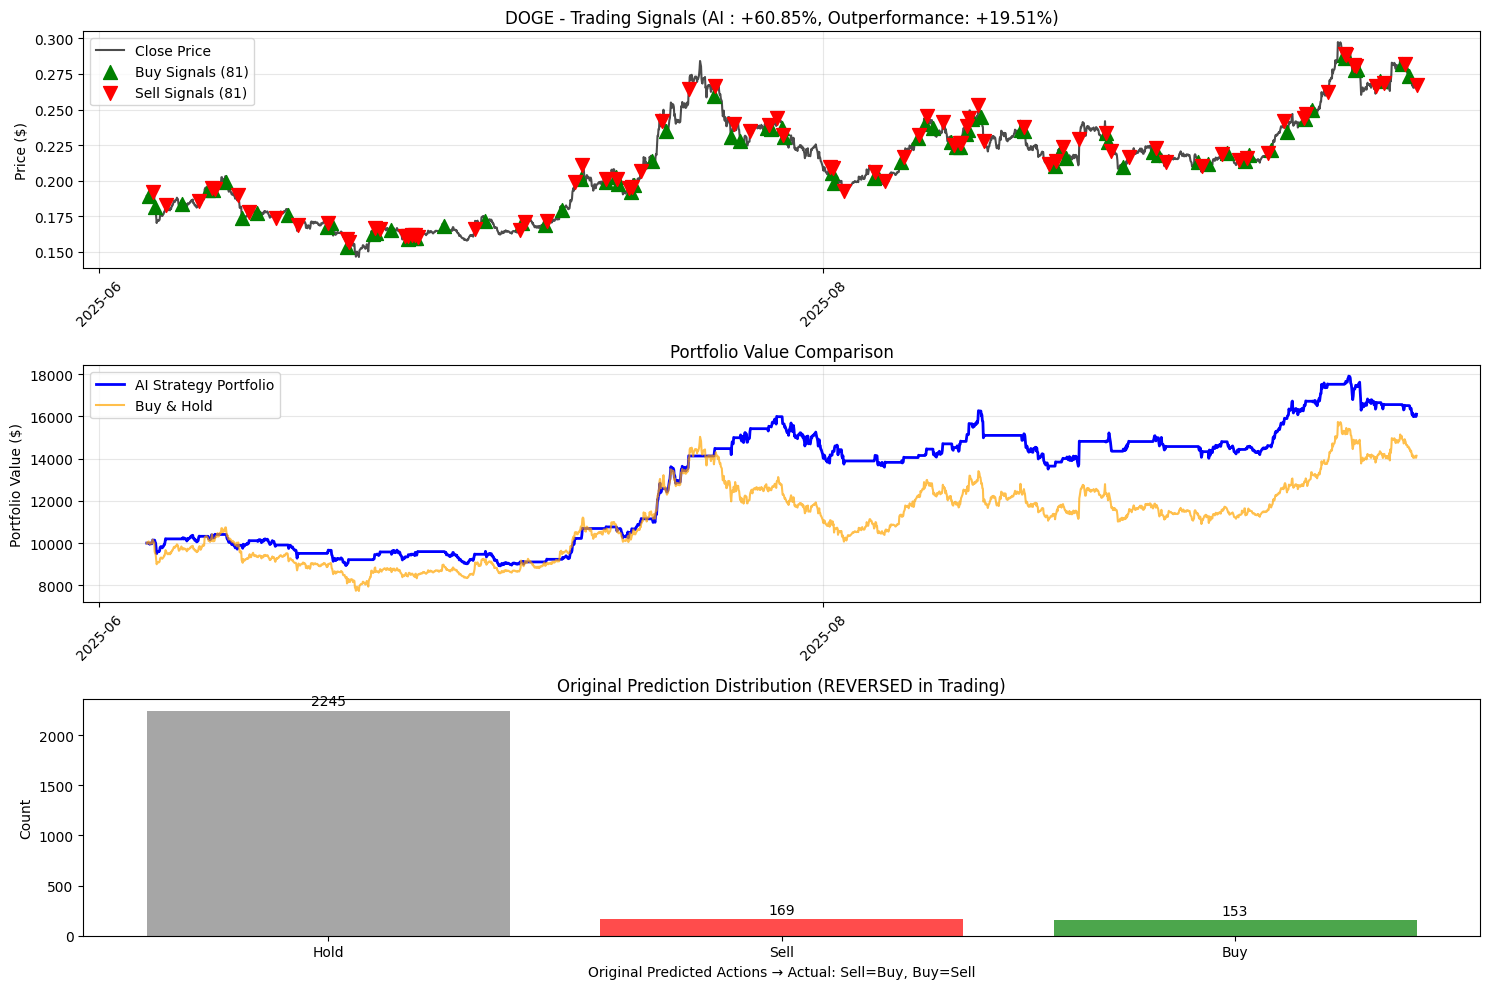

In [4]:
# 차트 보기
backtester = results['backtester']
backtester.plot_top_performers()  # 상위 25% 차트 표시

# 연도별 백테스팅 실행

In [23]:
# # 연도별 백테스팅 실행
# if __name__ == "__main__":
    
#     # 백테스팅할 연도 범위 설정
#     start_year = 2022
#     end_year = 2024
    
#     # 각 연도별 결과 저장
#     yearly_results = {}
    
#     print("연도별 백테스팅 시작")
#     print("=" * 50)
    
#     for year in range(start_year, end_year + 1):
#         print(f"\n{year}년 백테스팅 실행 중...")
        
#         try:
#             # 해당 연도 기간 설정
#             start_date = f'{year}-01-01'
#             end_date = f'{year}-12-31'
            
#             # 백테스팅 실행
#             backtester = run_individual_backtest(
#                 data_path=save_path_1,
#                 start_date=start_date,
#                 end_date=end_date,
#                 max_stocks=None,     
#                 top_percentage=0.25,  # 상위 20%          # 처음 n개 종목만 테스트
#                 initial_capital=10000
#             )
            
#             # 해당 연도 결과 저장
#             yearly_results[year] = {
#                 'backtester': backtester,
#                 'period': f'{start_date} ~ {end_date}'
#             }
            
#             print(f"{year}년 백테스팅 완료")
            
#         except Exception as e:
#             print(f"{year}년 백테스팅 실패: {e}")
#             yearly_results[year] = None
    
#     print("\n" + "=" * 50)
#     print("전체 연도별 백테스팅 완료")
    
#     # 연도별 결과 요약
#     print("\n연도별 결과 요약:")
#     for year, result in yearly_results.items():
#         if result is not None:
#             print(f"{year}년: 성공")
#         else:
#             print(f"{year}년: 실패")